   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0   

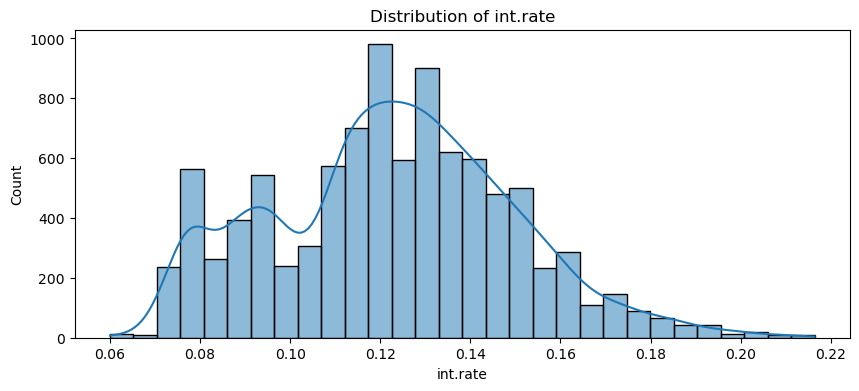

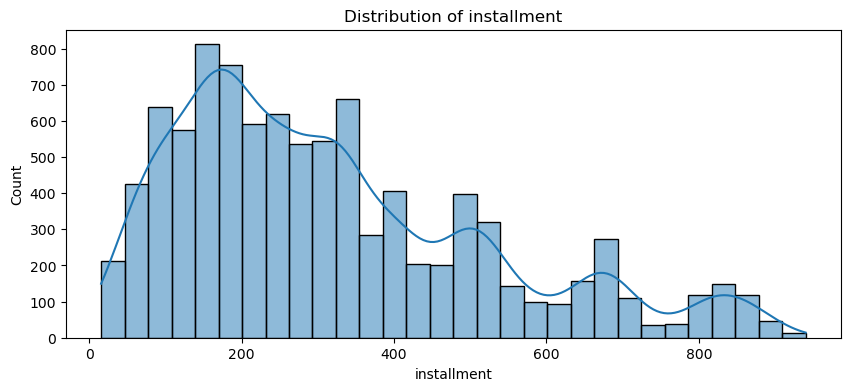

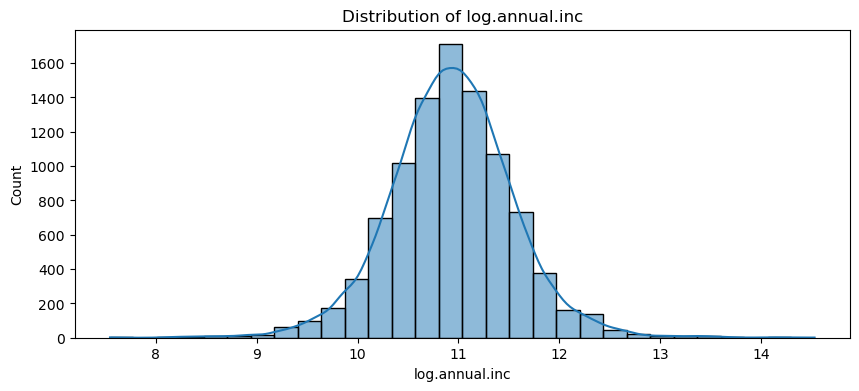

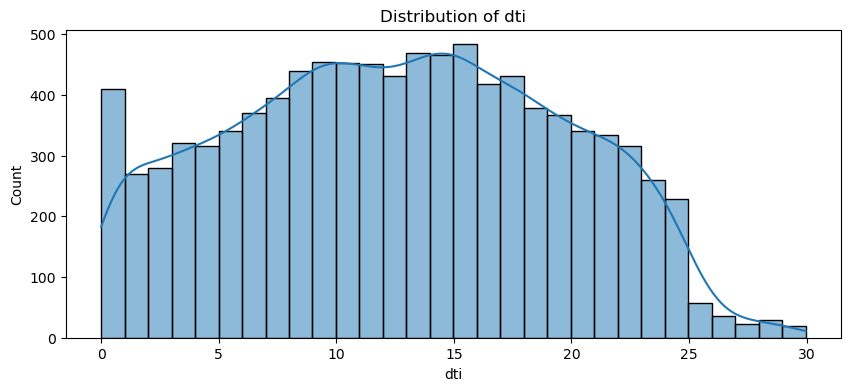

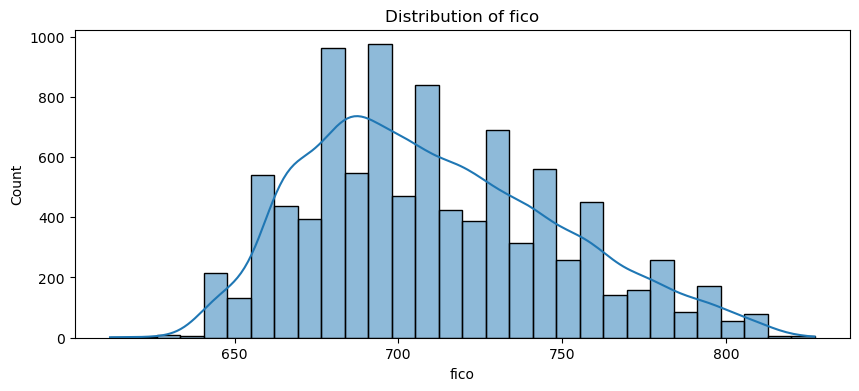

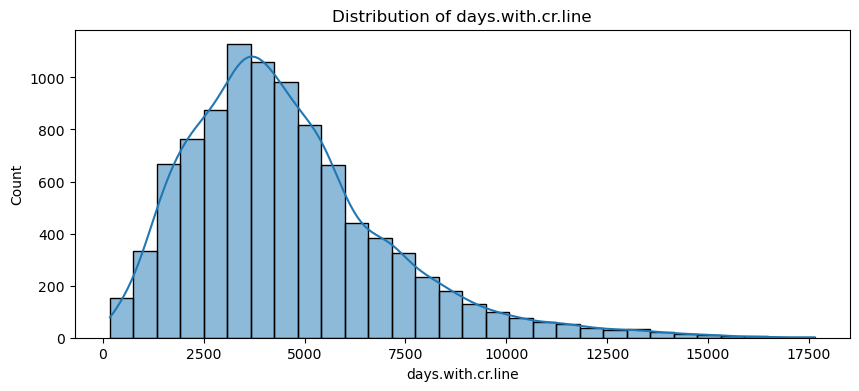

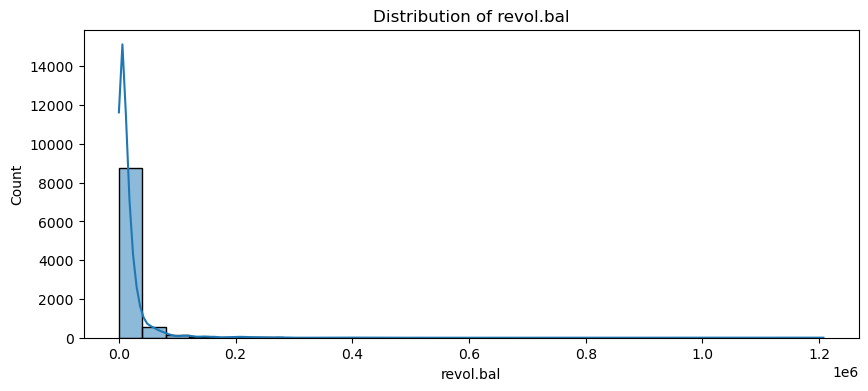

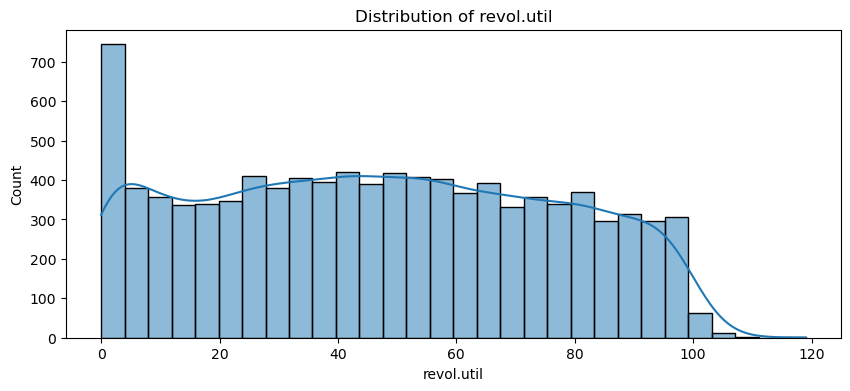

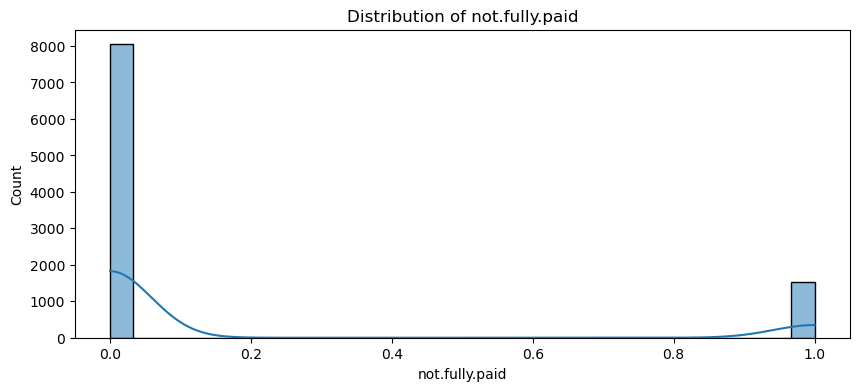

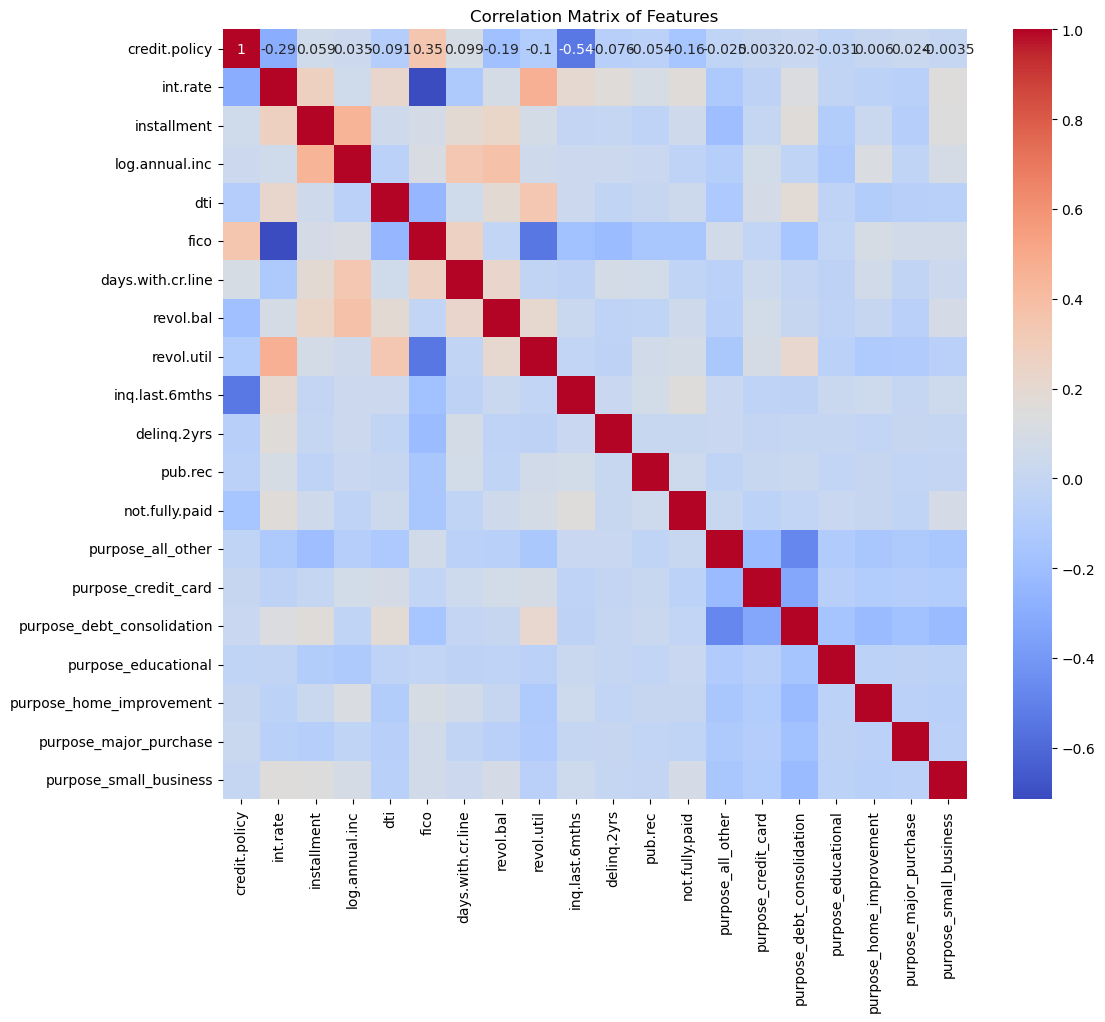

Best: 0.825668 using {'batch_size': 64, 'epochs': 300}
Epoch 1/300
202/202 [==============================] - 1s 3ms/step - loss: 0.5341 - accuracy: 0.7315 - val_loss: 0.4107 - val_accuracy: 0.8045
Epoch 2/300
202/202 [==============================] - 0s 2ms/step - loss: 0.4216 - accuracy: 0.7975 - val_loss: 0.3751 - val_accuracy: 0.8176
Epoch 3/300
202/202 [==============================] - 0s 2ms/step - loss: 0.3993 - accuracy: 0.8074 - val_loss: 0.3670 - val_accuracy: 0.8179
Epoch 4/300
202/202 [==============================] - 0s 2ms/step - loss: 0.3885 - accuracy: 0.8133 - val_loss: 0.3669 - val_accuracy: 0.8195
Epoch 5/300
202/202 [==============================] - 0s 2ms/step - loss: 0.3848 - accuracy: 0.8131 - val_loss: 0.3645 - val_accuracy: 0.8222
Epoch 6/300
202/202 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8142 - val_loss: 0.3615 - val_accuracy: 0.8269
Epoch 7/300
202/202 [==============================] - 0s 2ms/step - loss: 0.3812 - acc

In [1]:
# Import the necessary libraries for data manipulation, visualization, machine learning, and deep learning
import pandas as pd  # For handling and manipulating dataset
import numpy as np  # For numerical calculations and operations
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import seaborn as sns  # For creating statistical graphics
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For standardizing features by removing the mean and scaling to unit variance
from sklearn.metrics import confusion_matrix, classification_report  # For evaluating the model's performance
import tensorflow as tf  # TensorFlow, for building deep learning models
from tensorflow import keras  # Keras, a high-level neural networks API running on top of TensorFlow
from tensorflow.keras import Sequential  # For sequential model creation in Keras
from tensorflow.keras.layers import Dense, Dropout  # Dense for fully connected layers, Dropout for regularization
from imblearn.over_sampling import SMOTE  # For oversampling minority class in imbalanced datasets
from sklearn.model_selection import GridSearchCV  # For hyperparameter optimization
from scikeras.wrappers import KerasClassifier, KerasRegressor  # To wrap Keras models for use with scikit-learn
import warnings  # For suppressing warnings

# Suppress warnings of future versions of libraries
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and display the dataset
df = pd.read_csv('loan_data.csv')  # Load dataset from a CSV file
print(df.head())  # Display the first five rows of the dataset
print(df.describe())  # Display a statistical summary of the dataset
print(df.isnull().sum())  # Print the sum of missing values for each column

# Data cleaning and preprocessing
df = df.dropna()  # Remove rows with missing values
df = pd.get_dummies(df, columns=['purpose'])  # Convert 'purpose' column into dummy variables
purpose_columns = [col for col in df.columns if col.startswith('purpose_')]

# Exploratory Data Analysis (EDA)
# Visualize the distribution of various numerical features
numerical_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'not.fully.paid']
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[feature], kde=True, bins=30)  # Plot histograms with kernel density estimate
    plt.title(f'Distribution of {feature}')
    plt.show()

# Visualize the correlation matrix to understand the relationship between features
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  # Plot heatmap of the correlation matrix
plt.title('Correlation Matrix of Features')
plt.show()

# Feature engineering: Create new features that might improve model performance
df['credit_to_income'] = df['days.with.cr.line'] / (df['log.annual.inc'] + 1e-10)  # Avoid division by zero
df['installment_to_income'] = df['installment'] / (df['log.annual.inc'] + 1e-10)
df['debt_to_income'] = df['revol.bal'] / (df['dti'] + 1e-10)
df['utilization_rate'] = df['revol.bal'] / (df['revol.util'] + 1e-10)

# Update the list of numerical features to include the new features
numerical_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'credit_to_income', 'installment_to_income', 'debt_to_income', 'utilization_rate', 'credit.policy'] + purpose_columns

# Prepare the data for training
X = df[numerical_features]  # Features for model input
y = df['not.fully.paid']  # Target variable

# Address class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Scale features to normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a function to create a Keras model for classification
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),  # Input layer
        tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
        tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Determine the input dimension for the model
input_dim = X_train.shape[1]

# Wrap the model using KerasClassifier to use with scikit-learn
model = KerasClassifier(model=create_model, model__input_dim=input_dim, epochs=100, batch_size=10, verbose=0)

# Define parameters for grid search to find the best model configuration
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [100, 200, 300]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, error_score='raise')
grid_result = grid.fit(X_train, y_train)

# Print the best score and parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Train the final model using the best parameters
model = create_model(input_dim)
model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'], validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

# Generate predictions and evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# Assuming additional evaluation using external dataset
y_true = pd.read_csv('output.csv')  # Output from external dataset
X_test = pd.read_csv('input.csv')  # Features for prediction
# y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Model predictions
# print(confusion_matrix(y_true, y_pred))
# print(classification_report(y_true, y_pred, zero_division=0))
